# Benchmark CUDA FFTs using cupy and Compare with Numpy CPU
---

This notebook evaluate 2D FFT runtime for:
- Numpy on a CPU
- cupy FFT run serially
- cupy FFT run in batch mode.

In [1]:
import cupy as cp 
import time 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def measure_fft_timeNP(shape, num_trials=10): 
    data = np.random.random(shape) + 1j * np.random.random(shape)
    #cp.cuda.Device(0).synchronize() 
    start_time = time.time() 
    for _ in range(num_trials): 
        np.fft.fft2(data) 
        #cp.cuda.Device(0).synchronize() 
        return (time.time() - start_time) / num_trials 

In [3]:
def measure_fft_time(shape, num_trials=10): 
    data = cp.random.random(shape) + 1j * cp.random.random(shape)
    cp.cuda.Device(0).synchronize() 
    start_time = time.time() 
    for _ in range(num_trials): 
        cp.fft.fft2(data) 
        cp.cuda.Device(0).synchronize() 
    return (time.time() - start_time) / num_trials 

In [4]:
def batch_fft_2d(n, m, batch_size):
    """
    Perform batch 2D FFTs on the GPU using CuPy, and measure execution time.

    Parameters:
    - n: number of rows in each FFT
    - m: number of columns in each FFT
    - batch_size: the number of 2D FFTs to process in parallel

    Returns:
    - output_data: The result of the batch of FFTs.
    - execution_time: Time taken to execute the FFTs in milliseconds.
    """
    # Create a batch of random input data (complex)
    input_data = cp.random.randn(batch_size, n, m).astype(cp.complex64)

    # Create CUDA events to measure time
    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()

    # Record the start time
    start_event.record()

    # Execute the batch of 2D FFTs on the GPU using CuPy's FFT
    output_data = cp.fft.fft2(input_data)

    # Record the end time
    end_event.record()

    # Wait for the event to complete
    end_event.synchronize()

    # Calculate the elapsed time in milliseconds
    execution_time = cp.cuda.get_elapsed_time(start_event, end_event)  # Time in milliseconds

    # Transfer the result back to the CPU
    output_data_cpu = cp.asnumpy(start_event, end_event)  # CuPy array -> NumPy array

    return output_data_cpu, execution_time/batch_size/1000.


In [5]:
def prime_factors(n):
    factors = []

    while n % 2 == 0:
        factors.append(2)
        n //= 2
    for i in range(3, int(n**0.5) + 1, 2):
        while n % i == 0:
            factors.append(i)
            n //= i

    if n > 2:
        factors.append(n)
    return factors

## CPU Numpy FFT

In [6]:
fftMinNP, fftMaxNP = 64, 512
x = np.linspace(fftMinNP, fftMaxNP, num=fftMaxNP-fftMinNP+1)
y = np.linspace(fftMinNP, fftMaxNP, num=fftMaxNP-fftMinNP+1)
X, Y = np.meshgrid(x, y)
resultNP = np.zeros(X.shape)
i = 0
for i in range(fftMinNP, fftMaxNP):
    if(i % 10 == 0):
        print(f'{i}-', end='')
    for j in range(fftMinNP, fftMaxNP): 
        resultNP[i - fftMinNP, j-fftMinNP] = measure_fft_timeNP((i,j), num_trials=1)     

70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-

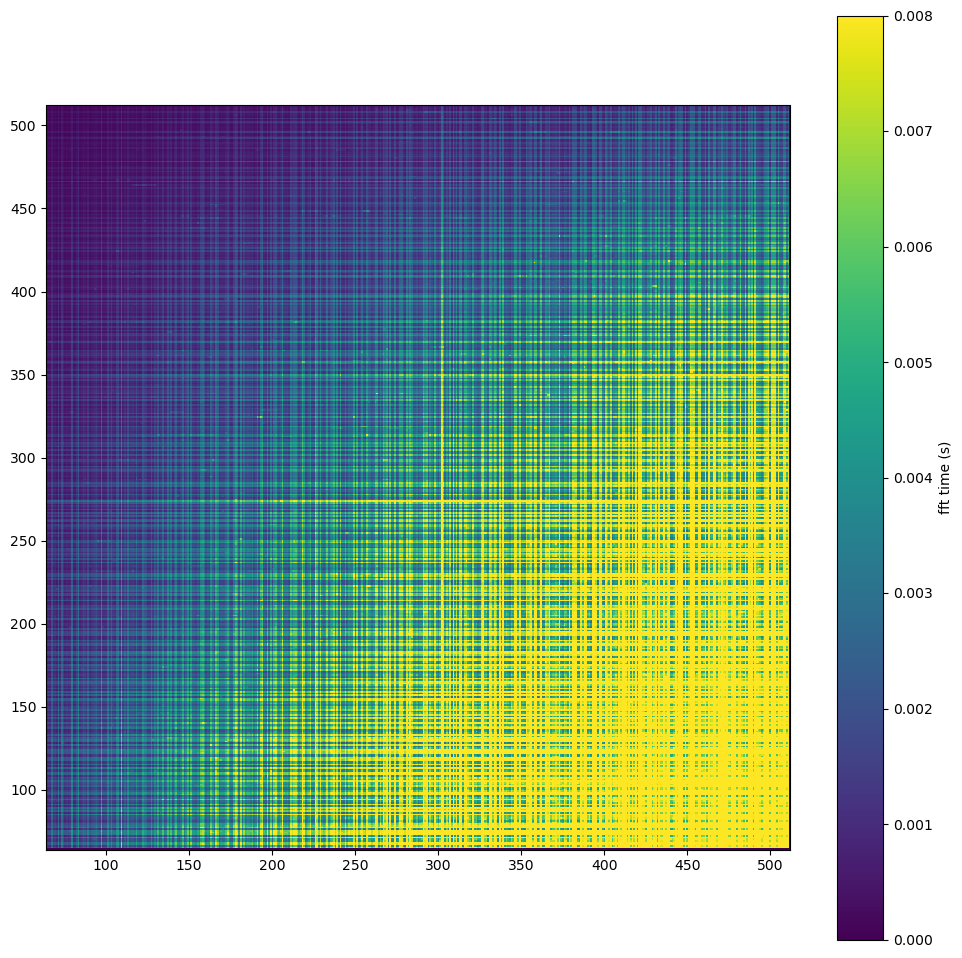

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
im = ax.imshow(resultNP, interpolation='None',  vmin=0, vmax=0.008, extent=[fftMinNP, fftMaxNP, fftMinNP, fftMaxNP])
cb = fig.colorbar(im)
cb.set_label('fft time (s)')

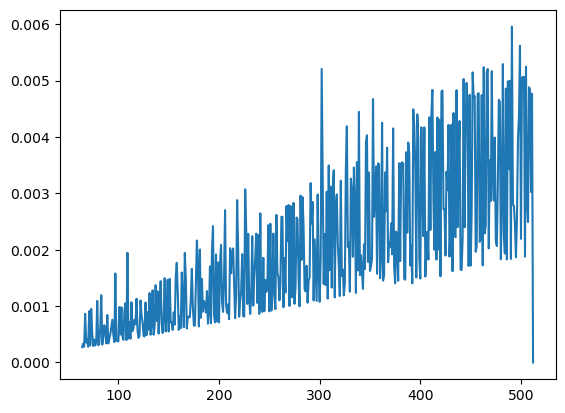

In [22]:
plt.plot(np.arange(fftMin, fftMax+1),resultNP[192-64, :])

Compute multiple FFTs in parallel.

## CUDA sequential FFTs

This calculates each FFT as a sequential request to the GPU.

In [9]:
fftMin, fftMax = 64, 512
num_trials = 25
x = np.linspace(fftMin, fftMax, num=fftMax-fftMin+1)
y = np.linspace(fftMin, fftMax, num=fftMax-fftMin+1)
X, Y = np.meshgrid(x, y)
resultSingle = np.zeros(X.shape)
maxF = np.zeros(X.shape)
for i in range(fftMin, fftMax+1):
    if(i % 10 == 0):
        print(f'{i}-', end='')
    for j in range(fftMin, fftMax+1): 
        resultSingle[i - fftMin, j - fftMax] = measure_fft_time((i,j), num_trials=num_trials) 
        maxF[i - fftMin, j - fftMax] = max(prime_factors(i) + prime_factors(j))

70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-

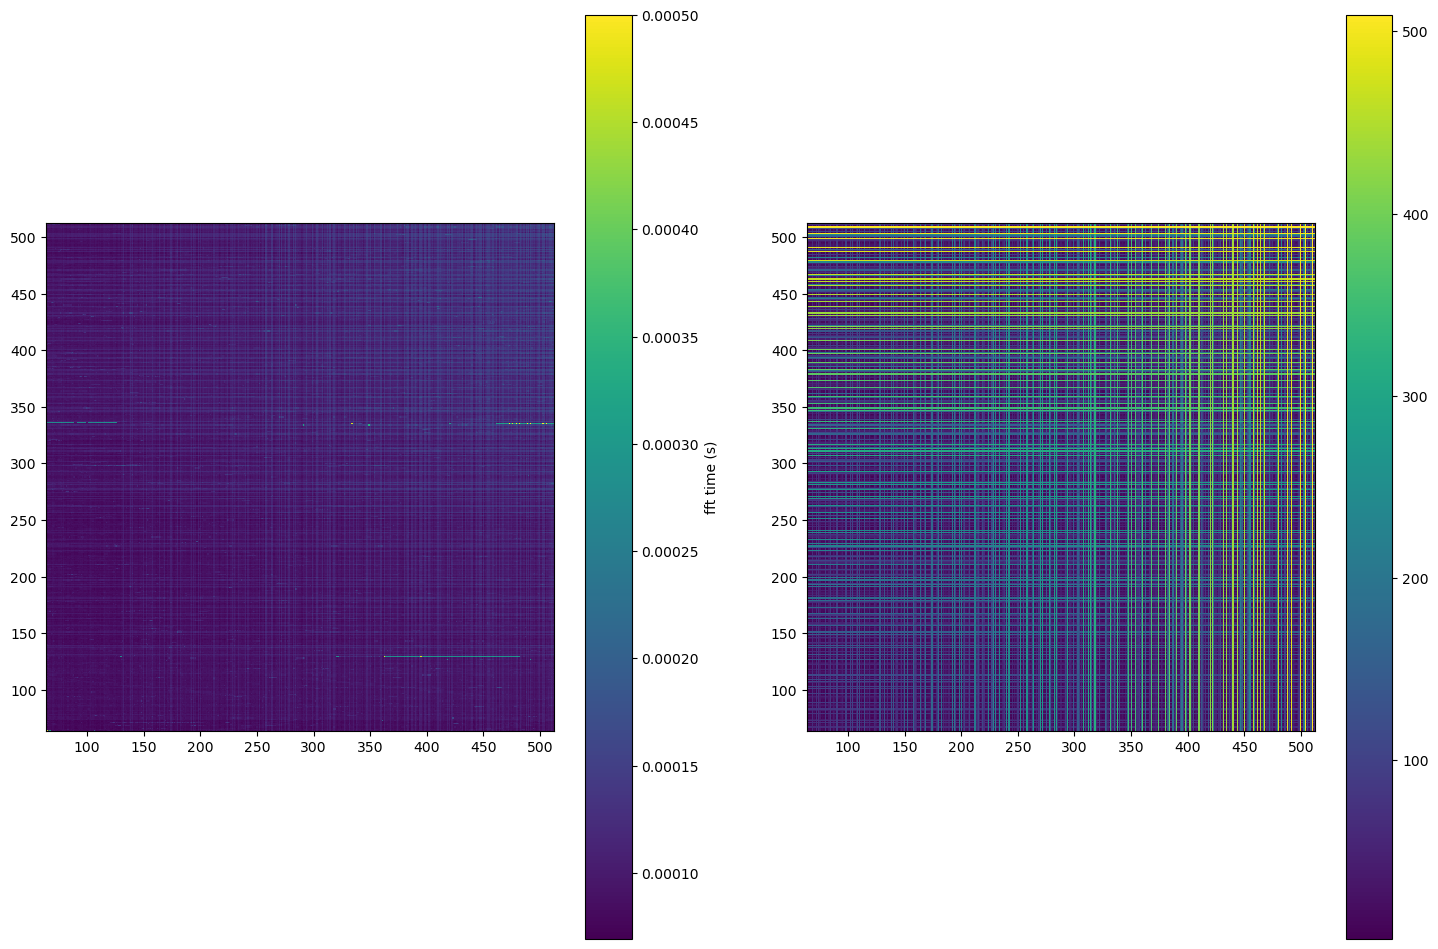

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
im = ax[0].imshow(resultSingle, vmax=.0005, interpolation='None', extent=[fftMin, fftMax, fftMin, fftMax], origin='lower')
cb = fig.colorbar(im)
cb.set_label('fft time (s)')
im1 = ax[1].imshow(maxF, interpolation='None', extent=[fftMin, fftMax, fftMin, fftMax], origin='lower')
cb = fig.colorbar(im1)

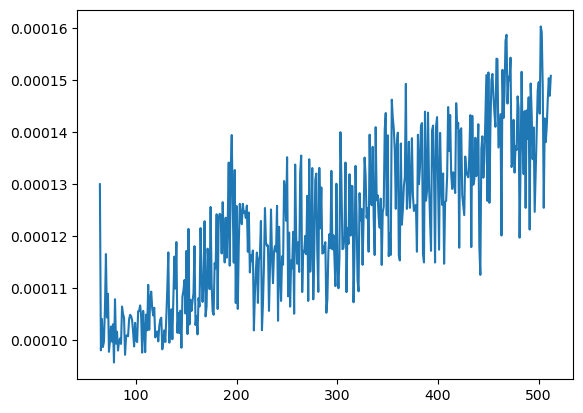

In [23]:
x = resultSingle[250, :]
plt.plot(range(fftMin, fftMax+1), x)

In [12]:
for i in [(192, 98), (224, 192), (212, 144), (216, 144), (212+8, 144+8), (224, 160),   (96, 64)]:
    fft_time = measure_fft_time(i, num_trials=200)
    rgLargest = max(prime_factors(i[0]))
    azLargest = max(prime_factors(i[1]))        
    print(f'rg={i[0]}, az={i[1]} fft={fft_time:.8f}  largest primes (rg, az)= {rgLargest}, {azLargest}')
for i in [(192, 98), (224, 192), (212, 144), (216, 144), (212+8, 144+8), (224, 160),   (96, 64)]:
    fft_time = measure_fft_time(i, num_trials=200)
    rgLargest = max(prime_factors(i[0]))
    azLargest = max(prime_factors(i[1]))        
    print(f'rg={i[0]}, az={i[1]} fft={fft_time:.8f}  largest primes (rg, az)= {rgLargest}, {azLargest}')

rg=192, az=98 fft=0.00007432  largest primes (rg, az)= 3, 7
rg=224, az=192 fft=0.00006569  largest primes (rg, az)= 7, 3
rg=212, az=144 fft=0.00006812  largest primes (rg, az)= 53, 3
rg=216, az=144 fft=0.00006660  largest primes (rg, az)= 3, 3
rg=220, az=152 fft=0.00006848  largest primes (rg, az)= 11, 19
rg=224, az=160 fft=0.00006567  largest primes (rg, az)= 7, 5
rg=96, az=64 fft=0.00006566  largest primes (rg, az)= 3, 2
rg=192, az=98 fft=0.00006808  largest primes (rg, az)= 3, 7
rg=224, az=192 fft=0.00007082  largest primes (rg, az)= 7, 3
rg=212, az=144 fft=0.00006704  largest primes (rg, az)= 53, 3
rg=216, az=144 fft=0.00006549  largest primes (rg, az)= 3, 3
rg=220, az=152 fft=0.00006846  largest primes (rg, az)= 11, 19
rg=224, az=160 fft=0.00006371  largest primes (rg, az)= 7, 5
rg=96, az=64 fft=0.00006287  largest primes (rg, az)= 3, 2


## Batch FFT

Compute multiple FFTs in parallel.

In [13]:
resultBatch = np.zeros(X.shape)
for i in range(fftMin, fftMax+1):
    if(i % 10 == 0):
        print(f'{i}-', end='')
    for j in range(fftMin, fftMax+1): 
        resultBatch[i - fftMin, j - fftMin] = batch_fft_2d(i, j, num_trials)[1] 

70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-

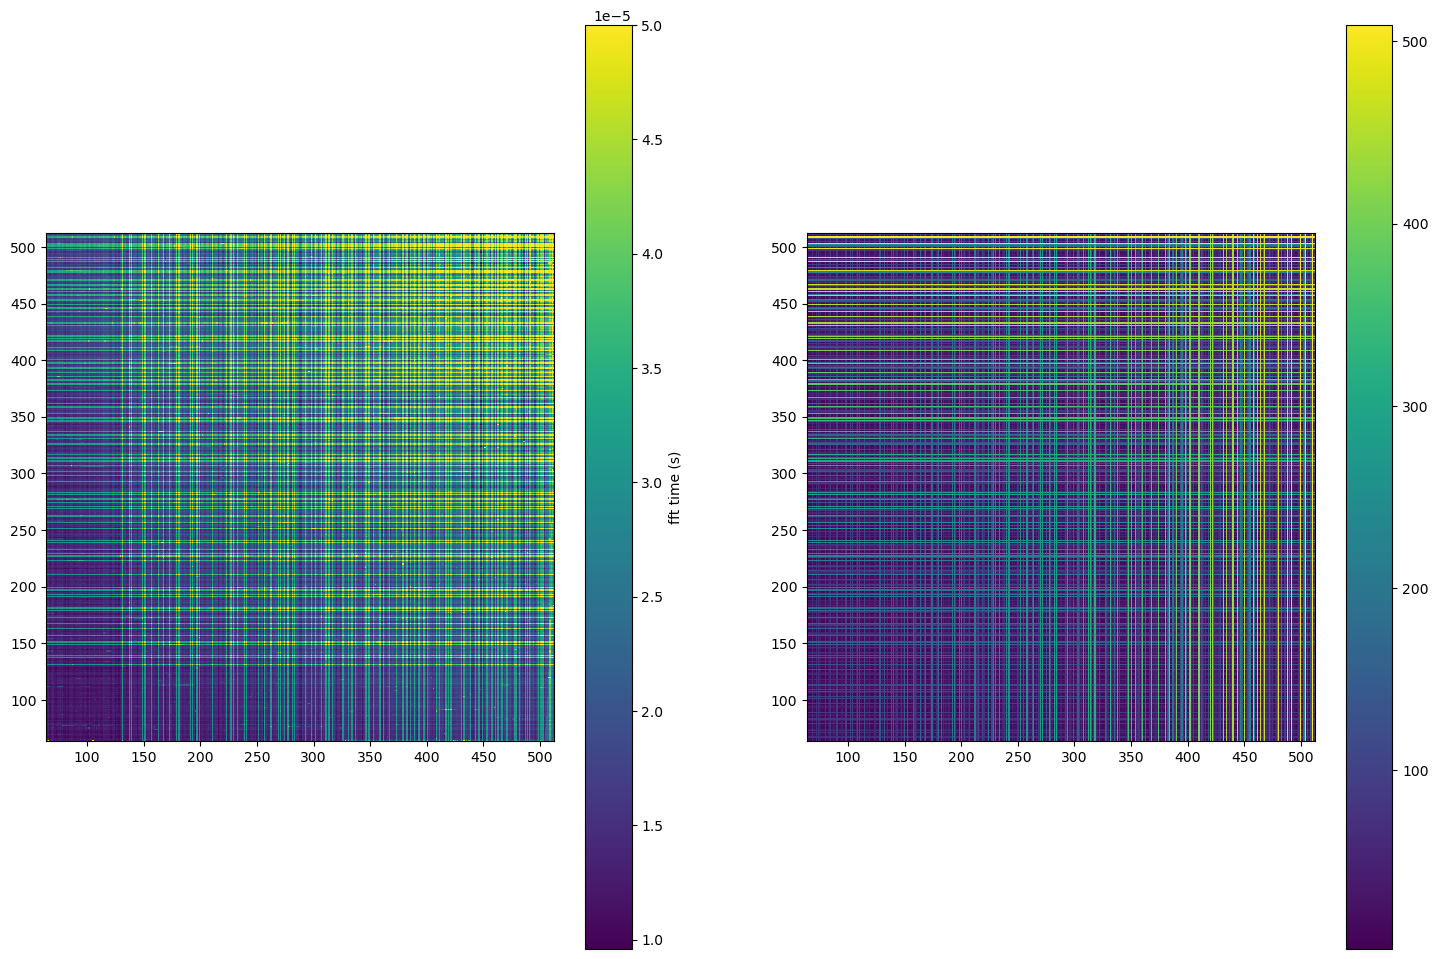

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
im = ax[0].imshow(resultBatch, vmax=.00005, interpolation='None', extent=[fftMin, fftMax, fftMin, fftMax], origin='lower')
cb = fig.colorbar(im)
cb.set_label('fft time (s)')
im1 = ax[1].imshow(maxF, interpolation='None', extent=[fftMin, fftMax, fftMin, fftMax], origin='lower')
cb = fig.colorbar(im1)

319
[11, 29]


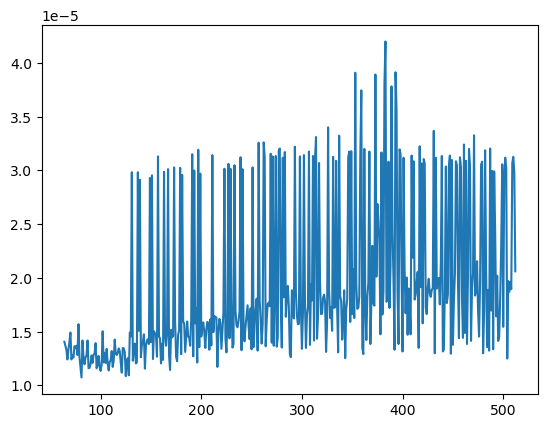

In [20]:
x = resultBatch[192-64, :]
plt.plot(np.arange(fftMin, fftMax+1), x)
print(np.argmax(x))
print(prime_factors(np.argmax(x)))